<a href="https://colab.research.google.com/github/sauddy/DPNNet-Bayesian/blob/main/DPNNet_Bayesian_FP_Prediction_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predict Planet Mass Using Disk Planet Neural Network (DPNNet-Bayesian) 

This code loads the trained model and is used to predict the planet masses presented in the paper

LInk to the published paper

[Using Bayesian Deep Learning to Infer Planet Mass from Gaps in Protoplanetary Disks](https://https://iopscience.iop.org/article/10.3847/1538-4357/ac7a3c)

In [ ]:
'''
    Introduction to DPNNet (Disk Planet Neural Network)
    
    AIM: To apply DPNNet to evaluate planet mass from observed Protoplanetary Disk Gaps in dust emission
    
    Application: 1. Apply the trained network to test-dataset to compare model performance
                 2. Demonstrate the application of the model to predict planet masses in HL Tau and AS 209
                 3. Compare with Kanagawa and Lodato models with error estimate
                 
    Background:  The DPNNet is trained using the simulation data: We import the trained Model
                 with it's optimized weights.
    
    This script modified version of the one used in Auddy & Lin 2020 paper

    December 15 2021: We update the script and made the plots for the Bayesian Paper
    December 28 2021: We update the script to estimate the combined uncertainty for HL Tau and AS 209
                      We now is addition to just estimateing the epistemic uncertainty add the aploetoric 
                      by considering an error of 5 percent in the estimate of the dust-gap.
                      Other input parameters are not varied as gap width is the leading source of uncertanty
    
    
'''

# Author :Sayantan
# Created : 2 June 2021
# Modified:  25 August: Now includes the Flaring Index and is the modular version

import pathlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib as mpl

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import h5py

import scipy as sp
from sklearn.metrics import r2_score ## form calcualting the r2 score

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
# plt.style.use('classic')
import numpy as np
print(tf.__version__)

2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
Path_gdrive= '/content/drive/MyDrive/DPNNet-FP-Bayesian/FP_bayesian_MLP_version/'
import os
os.chdir(Path_gdrive)
## Import the dpnnet_class
import dpnnet_class as dp
!mkdir -p figure_Paper ## to save the figures

We have imported the dpnnet_class


In [ ]:
## Import the data 

dataset_path ='/content/drive/MyDrive/DPNNet-FP-Bayesian/analysis_output_3000_FI/'

Model = dp.dpnnet(data_path=dataset_path)
dataset = Model.data_filtering()

dataset        # to take a look at the dataset e dataset 

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2,Flaring_index
0,54.000000,0.0169,0.00344,0.0219,0.0711,0.1430,0.071,0.0,0.0544
1,35.000000,0.0387,0.00368,0.0617,0.0470,0.4560,0.767,0.0,0.0471
2,109.000000,0.0641,0.00103,0.0576,0.0936,0.3620,1.032,0.0,0.2000
4,110.000000,0.0923,0.00580,0.0869,0.0917,0.0229,0.098,0.0,0.0699
5,106.666667,0.0253,0.00484,0.0298,0.0670,0.6600,0.838,0.0,0.2220
...,...,...,...,...,...,...,...,...,...
1108,110.333333,0.0860,0.00495,0.0073,0.0735,0.9320,0.753,0.0,0.0470
1109,23.333333,0.0732,0.00452,0.0423,0.0312,1.2200,0.713,0.0,0.1740
1110,70.333333,0.0630,0.00318,0.0379,0.0802,0.0936,0.795,0.0,0.1600
1111,104.000000,0.0537,0.00610,0.0723,0.0388,0.7710,0.823,0.0,0.0349


In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = Model.data_processing()

The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...


## Load the Saved Model and its weights

In [ ]:
# new_model = tf.keras.models.load_model('saved_model/my_model')
# # Check its architecture
model_name = "DPNNet_Bayesian_FP"  ## keras optimized weights
# model_name = "DPNNet_Bayesian_FP_p1"  ## same weights as paper 1
# model_name = "DPNNet_Bayesian_FP_p6"  ## same weights as paper 1 but a different version
# model_name = "DPNNet_Bayesian_FP_p44"  ## same weights as paper 1 but a different version 

file = h5py.File('saved_model/{}.h5'.format(model_name), 'r')
weight = []
for i in range(len(file.keys())):
   weight.append(file['weight' + str(i)][:])

## Building the model using the DPNNet-Bayesian Class
model = Model.build_model(unit1=None,unit2=None, Bayesian = True) ## Default weights set to paper 1
# model = Model.build_model(unit1=160,unit2=64, Bayesian = True)
model.set_weights(weight)
# new_model = model
model.summary()

We are now using the DPNNet Architecture
The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...
Implementing Bayesian in the last layer
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_variational (DenseVar  (None, 128)              98688     
 iational)                                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total par

# Model performance 

In [ ]:
# Model performance 

loss, mae, mse = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))


Testing set Mean Square Error: 176.37 
Testing set Root Mean Square Error: 13.28 M_Earth
Testing set Mean Abs Error:  9.92 M_Earth
Testing set Loss : 201.51 M_Earth


In [ ]:
## Calculating the Epistemic Uncertainty

## Use list comprehension tp predict over the test dataset for 200 times.
interval =200 ## This corresponds to the number of trials for the epistemic uncerstainty
yhat = [model.predict(X_test_scaled).flatten() for _ in range(interval)]
df  = pd.DataFrame(yhat).T
df['y'] = y_test.values
df.head()
# df.values

import itertools
sample_preds = list(itertools.chain.from_iterable([[(j,x[-1]) for j in x if j != x[-1]]for x in df.values]))
# sample_preds
# df.shape()

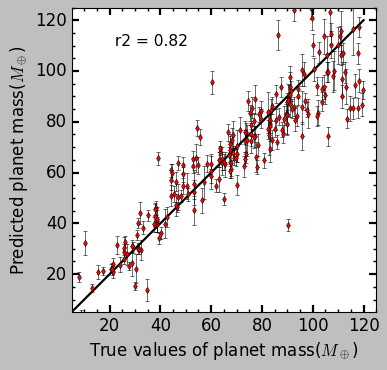

In [ ]:
plt.style.use('classic')
df.shape[0]
N=0
# interval=200
pred_value_mean = []
pred_value_std = []
actual_value = []
for i in range (0,df.shape[0]):
  predicted_values = [x[0] for x in sample_preds[N:N+interval]]
  actual_values = [x[1] for x in sample_preds[N:N+interval]]
  N = interval + N
  pred_value_mean.append(np.mean(predicted_values))
  pred_value_std.append(np.std(predicted_values))
  actual_value.append(np.mean(actual_values))

r_score = r2_score(actual_value,pred_value_mean)

plt.figure(figsize = (5,5))
# plt.scatter([x[1] for x in sample_preds],[x[0] for x in sample_preds],alpha = 0.01,c = 'r')
plt.scatter(actual_value,pred_value_mean,alpha = 0.01,c = 'r')
plt.errorbar(actual_value,pred_value_mean, yerr=pred_value_std, lw=0,elinewidth=0.5,ecolor='k', fmt='d',markersize=4,color='red',capsize=2,label= 'DPNNet')
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2,c='k')
plt.text(20,110,r" r2 = {:.2f}".format(r_score), fontsize =14)
plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
# plt.savefig('figure_Paper/predicted_correlation.jpeg',format='jpeg',dpi=600)

In [ ]:
# plt.style.use('classic')
# plt.figure(figsize = (5,5))
# # test_predictions = model.predict(normed_test_data).flatten()
# # plt.scatter(test_labels, test_predictions,s=30,marker='d',color='r')
# plt.scatter([x[1] for x in sample_preds],[x[0] for x in sample_preds],alpha = 0.01,c = 'r')
# plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
# plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
# plt.axis('equal')
# plt.axis('square')
# plt.xlim(5,135)
# plt.ylim(5,135)
# # plt.xlim([0.6,plt.xlim()[1]])
# # plt.ylim([0.6,plt.xlim()[1]])
# _ = plt.plot([0, 130], [0, 130],linewidth=2,c='k')

# plt.minorticks_on() 
# plt.tick_params(labelsize=15)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
# plt.tight_layout()
# # plt.savefig('figure_Paper/predicted_correlation.jpeg',format='jpeg',dpi=600)
# # plt.savefig(output_figure +'/predicted_correlation.pdf',format='pdf',dpi=300)
# # plt.savefig('figures/predicted_correlation.eps',format='eps',dpi=300)

## Using DPNNet to predict the planet mass from observed gap widths in HL-Tau

In [ ]:
#  Lets predict the Mass of Hl Tau disk
np.random.seed(2)
## need to guess from the observation
Epsilon = 0.01
SigmaSlope = .8 ## this is the mean value from the parameter space
Stokes = 0.005
Alpha = 0.001
Flaring_index = 0.2 ## Need to update this

## Will use the values from the Kanagawa paper
Aspect_Ratio= [0.05,0.07,0.1]
Dust_gap = [0.81,0.23,0.29]

Dust_gap_2 = 0.000 ## using a default value of zero
N =1000
yhat_hL_tau = np.empty((len(Aspect_Ratio), N))
for index in range(len(Aspect_Ratio)):
    df_HL = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio[index],SigmaSlope,Dust_gap[index],Dust_gap_2,Flaring_index]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
    print("The Predicted planet mass in ring#",index,"is",model.predict(Model.normalization(df_HL)))

    ## Use list comprehension tp predict over the test dataset for 100 times.
    # yhat = [model.predict(norm(df_HL)).flatten() for _ in range(N)]  
    yhat_hL_tau[index,:] = [model.predict(Model.normalization(df_HL)).flatten() for _ in range(N)]  




The Predicted planet mass in ring# 0 is [[85.96663]]
The Predicted planet mass in ring# 1 is [[46.850853]]
The Predicted planet mass in ring# 2 is [[98.57463]]


86.0 4.0


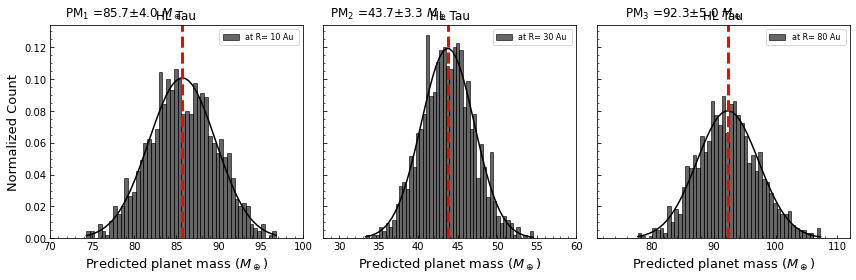

In [ ]:
df_HL_Tau  = pd.DataFrame(yhat_hL_tau).T
bi= 50

f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey = True ,sharex=False,figsize=(12,4))
ax1.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
count, bins, _ = ax1.hist(df_HL_Tau[0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 10 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# xmin, xmax = 110, 140
# x_ = np.linspace(xmin, xmax, 41)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL_Tau[0].min()-2.5
# print(x_start)
y_pos = count.max()*1.3
ax1.set_xlim(70,100)
ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.set_title("HL Tau")
_, bins, _ = ax2.hist(df_HL_Tau[1], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 30 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[1])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL_Tau[1].min()-4.5
ax2.minorticks_on() 
ax2.set_xlim(28,60)
ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax2.set_title("HL Tau")
_, bins, _ = ax3.hist(df_HL_Tau[2], bins=bi,alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 80 Au ")
mu, sigma = sp.stats.norm.fit(df_HL_Tau[2])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax3.plot(bins, best_fit_line,color="k")
ax3.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL_Tau[2].min()-2
ax3.text(x_start,y_pos,r"$\rm PM_3$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax3.set_xlim(71,112)
ax3.minorticks_on() 
ax3.set_title("HL Tau")
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
# ax1.set_ylabel(r'Count',fontsize=13)


# # plt.axis('equal')
# plt.axis('square')
plt.tight_layout()
# plt.savefig('figure_Paper/HL_Tau.jpeg',format='jpeg',dpi=600,bbox_inches = 'tight')

## Using DPNNet to predict the planet mass from observed gap widths in AS 209

In [ ]:
#Predict the planet mass in AS 209 disk
## Note that the central star in 0.83 M_{\sun}
# AS209_1 Paramters used from Zhang et al 2018

df_AS209=np.empty((2, N))
M_star = 0.83 ## from Zhang et al 2018
Dust_gap_2 = 0.00 ## using a default value of zero

Dust_gap = 0.42
Epsilon = 0.012 # 1.23/100
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.04
Flaring_index = 0.2 ## Need to update this

df_AS209_1 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
df_AS209[0,:] = [(model.predict(Model.normalization(df_AS209_1))*M_star).flatten() for _ in range(N)] 
print("The Predicted planet mass in ring AS209_1#",model.predict(Model.normalization(df_AS209_1))*M_star)

# AS209_2
Dust_gap = 0.31
Epsilon = 0.02   #####0.17/10
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.08
Flaring_index = 0.2 ## Need to update this

df_AS209_2 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
df_AS209[1,:] = [(model.predict(Model.normalization(df_AS209_2))*M_star).flatten() for _ in range(N)] 
print("The Predicted planet mass in ring AS209_2#",model.predict(Model.normalization(df_AS209_2))*M_star)

The Predicted planet mass in ring AS209_1# [[22.501215]]
The Predicted planet mass in ring AS209_2# [[33.041393]]


21.0 2.0


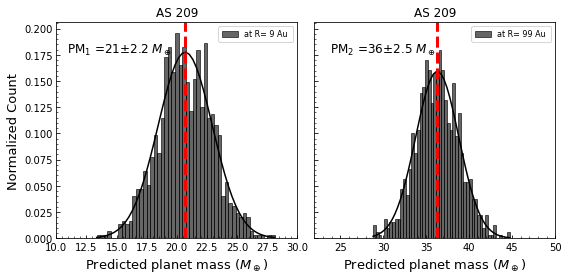

In [ ]:
# print(yhat)
df  = pd.DataFrame(df_AS209).T
# df.head()
# bi= 40
# ax[idx].hist(df.iloc[:,idx], bins=12, alpha=0.5)
# df[1].diff().hist(color="k", alpha=0.5, bins=50)
# df.iloc[0].diff().hist(color="k", alpha=0.5, bins=50)
# df.iloc[0].hist(bins=bins,density=True, facecolor='r', alpha=0.6)
# plt.figure()

f, [ax1,ax2] = plt.subplots(1, 2, sharey = True ,sharex=False,figsize=(8,4))
ax1.minorticks_on() 
count, bins, _ = ax1.hist(df[0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 9 Au ")
mu, sigma = sp.stats.norm.fit(df[0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df[0].min()-2.5
ax1.set_title("AS 209")
# print(x_start)
y_pos = count.max()*.9
ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.set_xlim(10,30)
ax2.minorticks_on() 
_, bins, _ = ax2.hist(df[1], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 99 Au ")
mu, sigma = sp.stats.norm.fit(df[1])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df[1].min()-5

ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.1}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)

ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
# ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
# ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
ax2.set_xlim(22,50)
ax2.set_title("AS 209")
# plt.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
# # plt.axis('equal')
# # plt.axis('square')
# plt.tight_layout()
# plt.axis('square')
plt.tight_layout()
# plt.savefig( "figure_Paper/AS209_planet_mass.jpeg",format='jpeg',dpi=600,bbox_inches = 'tight')
# plt.tight_layout()

## A test case for demonstration in the paper 

142    88.333333
Name: Planet_Mass, dtype: float64
Actual Planet Mass is  142    88.333333
Name: Planet_Mass, dtype: float64
Predicted Planet Mass is  75.37757


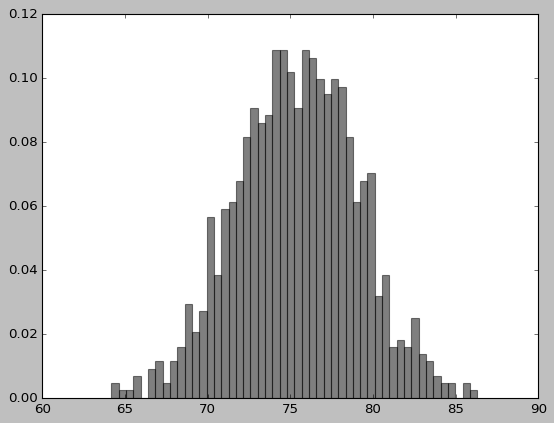

In [ ]:
## One test case for the demonstration in the paper ## Showing both epistemic and aleatoric uncertainties
test_index = 50
print(y_test.iloc[[test_index]])
print("Actual Planet Mass is ", y_test.iloc[[test_index]])
## Estimate the epistemic uncertainty  
N = 1000
# print(normed_test_data.iloc[[test_index]])
test_yhat = [model.predict(X_test_scaled.iloc[[test_index]]).flatten() for _ in range(N)]
test_yhat = np.reshape(test_yhat,(1,N)).flatten()
print("Predicted Planet Mass is " , np.mean(test_yhat))

plt.figure()
_, bins, _ = plt.hist(test_yhat, bins=50, alpha=0.5,color="k",edgecolor='k',density=True, label= "at R= 99 Au ")
plt.show()

In [ ]:
def alea_epis_uncertainty(input_params, params_sigma, N_epis, npts_aleo):
    '''
    This function calculates the aleatoric and the epistemic uncertainty associated with the input parameters.
    
    Inputs: 
            Parameter           : Epsilon, SigmaSlope, Stokes, Alpha, Aspect_Ratio,
                                  Dust_gap, Dust_gap_2,Flaring_index
            Params_uncertainty : Epsilon_sd, SigmaSlope_sd, Stokes_sd, Alpha_sd,
                                  Aspect_Ratio_sd, Dust_gap_sd, Dust_gap_2_Sd,Flaring_index 

            IF uncertainty not provided one can choose a variation percentage hard wired in the function itself             
                    
    Author:  Sayantan
    Created 3 June 2021
    Modified: 17 July 2021 
    
    '''

   

    ## Feature Variables
    # Epsilon_0, SigmaSlope_0, Stokes_0, Alpha_0, Aspect_Ratio_0, Dust_gap_0, Dust_gap_2_0,Flaring_index = input_params
    Epsilon_0,	Alpha_0,	Stokes_0,	Aspect_Ratio_0,	SigmaSlope_0,	Dust_gap_0,	Dust_gap_2_0,	Flaring_index_0 = input_params
    ## Feature Variables uncertainty 
    if params_sigma != []:
      Epsilon_sd, SigmaSlope_sd, Stokes_sd, Alpha_sd, Aspect_Ratio_sd, Dust_gap_sd, Dust_gap_2_sd,Flaring_index_sd = params_sigma
      print("The uncertainty is taken from the user")
    else:
      print("Give the uncertainty in the input paramters: or else we will take 10 percent variation")

      percentage_variation = 0.01
      try: ## When accepting input variables from the dataframe
        Epsilon_sd, SigmaSlope_sd, Stokes_sd, Alpha_sd, Aspect_Ratio_sd, Dust_gap_sd, Dust_gap_2_sd,Flaring_index_sd = [percentage_variation* i[0] for i in input_params]
      except TypeError : # When accepting input variables a user defines list directly
        Epsilon_sd, SigmaSlope_sd, Stokes_sd, Alpha_sd, Aspect_Ratio_sd, Dust_gap_sd, Dust_gap_2_sd,Flaring_index_sd= [percentage_variation* i for i in input_params]

    # print(Epsilon_sd, SigmaSlope_sd, Stokes_sd, Alpha_sd, Aspect_Ratio_sd, Dust_gap_sd, Dust_gap_2_sd)
   

    npts = npts_aleo
    N = N_epis

    yhat = np.empty((npts, N)) ## Store the predicted values
    print("The shape of the prediction list is ",np.shape(yhat))
    if npts_aleo != 1:
      
      Epsilon= Epsilon_0 + np.random.standard_normal((npts,))*Epsilon_sd
      SigmaSlope = SigmaSlope_0  + np.random.standard_normal((npts,))*SigmaSlope_sd
      Stokes = Stokes_0 + np.random.standard_normal((npts,))*Stokes_sd
      Alpha = Alpha_0 + np.random.standard_normal((npts,))*Alpha_sd ## 
      Aspect_Ratio = Aspect_Ratio_0 + np.random.standard_normal((npts,))*Aspect_Ratio_sd ## added 10% variation to sigma_{NT} by hand 
      Dust_gap = Dust_gap_0 + np.random.standard_normal((npts,))*Dust_gap_sd
      Dust_gap_2 = Dust_gap_2_0 + np.random.standard_normal((npts,))*Dust_gap_2_sd
      Flaring_index = Flaring_index_0 + np.random.standard_normal((npts,))*Flaring_index_sd
     
      
      for index in range(npts):
        print("Iteration #",index)
        df = pd.DataFrame(data=[[Epsilon[index],Alpha[index],Stokes[index],Aspect_Ratio[index],SigmaSlope[index],Dust_gap[index],Dust_gap_2[index],Flaring_index[index]]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
        ## Use list comprehension tp predict over the test dataset for N_epis times. 
        yhat[index,:] = [model.predict(Model.normalization(df)).flatten() for _ in range(N_epis)] 

    

    else:
      print("Performing Simple Epistemic With fixed input parameters")

      for index in range(npts):
        print("Iteration #",index)
        try: ## When accepting input variables from the dataframe
          # print(Epsilon_0,Alpha_0,Stokes_0,Aspect_Ratio_0,SigmaSlope_0,Dust_gap_0,Dust_gap_2_0,Flaring_index_0)
          df = pd.DataFrame(data=[[Epsilon_0[index],Alpha_0[index],Stokes_0[index],Aspect_Ratio_0[index],SigmaSlope_0[index],Dust_gap_0[index],Dust_gap_2_0[index],Flaring_index_0[index]]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
        except TypeError:  # When accepting input variables a user defines list directly
          # print(Epsilon_0,Alpha_0,Stokes_0,Aspect_Ratio_0,SigmaSlope_0,Dust_gap_0,Dust_gap_2_0,Flaring_index_0)
          df = pd.DataFrame(data=[[Epsilon_0,Alpha_0,Stokes_0,Aspect_Ratio_0,SigmaSlope_0,Dust_gap_0,Dust_gap_2_0,Flaring_index_0]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
        print(df)
        yhat[index,:] = [model.predict(Model.normalization(df)).flatten() for _ in range(N_epis)] 
     
     
    return (yhat)

In [ ]:
# input_params = np.reshape(normed_test_data.iloc[[test_index]].values.tolist(),(7,1)).flatten()
# input_params = normed_test_data.iloc[[test_index]].T.values.tolist() ## df to list after transposing 
test_index = 110
# print(dataset.iloc[[test_index],:1])

print("Actual Planet Mass is ", dataset.iloc[[test_index],:1])
input_params = dataset.iloc[[test_index],1:].T.values.tolist() ## df to list after transposing 
input_params = [input_params[i][0] for i in range(len(input_params))] ## to get in a list

# params_sigma = [0.001,0.1,0.0001,0.0001,0.001,0.05,0.0]
# input_params = [0.01,1,0.005,0.001,0.05,0.81,0,0]
params_sigma = []

print(input_params)

N_epis = 200
npts_aleo = 1000
# Predicted_AL_EP = alea_epis_uncertainty(input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)
# Predicted_AL = alea_epis_uncertainty(input_params, params_sigma, N_epis=1,npts_aleo=npts_aleo)


Actual Planet Mass is       Planet_Mass
112    46.333333
[0.0362, 0.00829, 0.0792, 0.0279, 1.11, 0.74, 0.0, 0.209]


In [ ]:
# Predicted_EP = alea_epis_uncertainty(input_params, params_sigma, N_epis=N_epis,npts_aleo=1)

# ### Changing to Dataframe for future use
# df_epis  = pd.DataFrame(Predicted_EP)
# df_Aleo  = pd.DataFrame(Predicted_AL.reshape(npts_aleo*1,1))
# df_Aleo_epis  = pd.DataFrame(Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

## Saving the monte Carlo for future use: 

# df_Aleo.to_csv(Path_gdrive+'data_folder/Predicted_AL_1.csv')
# df_Aleo_epis.to_csv(Path_gdrive+'data_folder/Predicted_AL_EP_1.csv')
# df_epis.to_csv(Path_gdrive+'data_folder/Predicted_EP_1.csv')


## Plot with the uncertainties for the test case

47.6 5.8
50.4 8.3
49.8 8.1


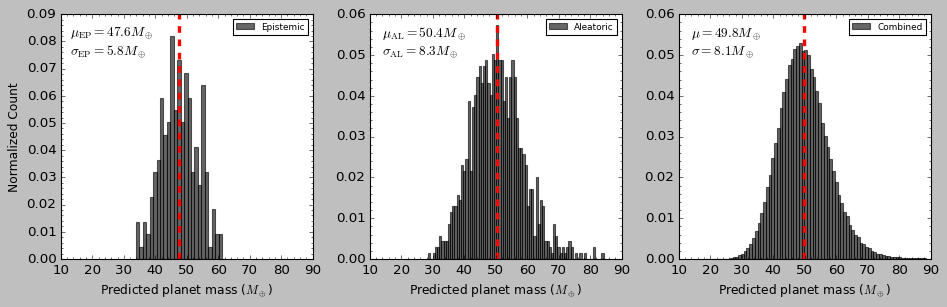

In [ ]:
plt.style.use('classic')
df_Aleo = pd.read_csv(Path_gdrive+'data_folder/Predicted_AL_1.csv',index_col=0)
df_Aleo_epis= pd.read_csv(Path_gdrive+'data_folder/Predicted_AL_EP_1.csv',index_col=0)
df_epis= pd.read_csv(Path_gdrive+'data_folder/Predicted_EP_1.csv',index_col=0)


# pd.read_csv
# df.head(10)
bi=25

# plt.figure(figsize=(5,5))
# plt.minorticks_on() 

f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey = False ,sharex=False,figsize=(12,4))

ax1.minorticks_on() 
cl, bins,_= ax1.hist(df_epis, bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,stacked=True,label= "Epistemic")
mu, sigma = sp.stats.norm.fit(df_epis)
print(round(mu,1),round(sigma,1))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start =df_Aleo_epis.iloc[:, 0].min()
# print(x_start)
# ax1.legend(loc='best')
# y_pos = 0.08
ax1.set_xlim(10,90)
x_start = 13
y_pos = 0.075
# ax1.text(x_start,y_pos,r"$\mu$ ={:.0f}$M_\oplus$".format(round(mu,0))+'\n'+r"$\sigma = ${:.0f} $M_\oplus$".format(round(sigma,0)),fontsize=12)
# ax1.set_ylim(0,.2)
ax1.text(x_start,y_pos,r"$\mu_{\rm EP}=%.1f$"%round(mu,1)+'$M_\oplus$ \n'+r"$\sigma_{\rm EP}=%.1f$"%round(sigma,1)+'$M_\oplus$')

cl, bins, _ = ax2.hist(df_Aleo.iloc[:, 0], bins=80, alpha=0.6,color="k",edgecolor='k',density=True,label= "Aleatoric")
mu, sigma = sp.stats.norm.fit(df_Aleo.iloc[:, 0])
print(round(mu,1),round(sigma,1))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
# x_start = df_Aleo_epis[0].min()
# print(x_start)
# ax2.legend(loc='best')
y_pos = 0.08
ax2.set_xlim(10,90)
x_start = 14
y_pos = 0.050
# ax2.text(x_start,y_pos,r"$\mu$={:.0f}$M_\oplus$".format(round(mu,0))+'\n'+r"$\sigma= ${:.0f} $M_\oplus$".format(round(sigma,0)),fontsize=12)
ax2.text(x_start,y_pos,r"$\mu_{\rm AL}=%.1f$"%round(mu,1)+'$M_\oplus$ \n'+r"$\sigma_{\rm AL}=%.1f$"%round(sigma,1)+'$M_\oplus$')
# ax2.set_ylim(0,.02)
ax2.minorticks_on() 

cl, bins, _ = ax3.hist(df_Aleo_epis.iloc[:, 0], bins=100, alpha=0.6,color="k",edgecolor='k',density=True,label= "Combined")
mu, sigma = sp.stats.norm.fit(df_Aleo_epis.iloc[:, 0])
print(round(mu,1),round(sigma,1))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# ax3.plot(bins, best_fit_line,color="k")
ax3.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
# x_start = df_Aleo_epis.iloc[:, 0].min()
x_start = 14
y_pos = 0.050
# ax3.text(x_start,y_pos,r"$\mu$ ={:.0f}$M_\oplus$".format(round(mu,0))+'\n'+r"$\sigma = ${:.0f} $M_\oplus$".format(round(sigma,0)),fontsize=12)
ax3.text(x_start,y_pos,r"$\mu=%.1f$"%round(mu,1)+'$M_\oplus$ \n'+r"$\sigma=%.1f$"%round(sigma,1)+'$M_\oplus$')
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
ax3.legend(loc=1,fontsize=8)
ax3.minorticks_on() 
# print(x_start)
# y_pos = 0.08

ax1.set_ylabel(r'Normalized Count',fontsize=11)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=11)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=11)
ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=11)
ax3.set_xlim(10,90)
# ax3.set_ylim(0,.02)
# plt.xlim(20,)
plt.tight_layout()
plt.savefig('figure_Paper/prediction_with_uncertainty.jpeg',format='jpeg',dpi=600)

In [ ]:
df_Aleo.shape
df_epis.shape
df_Aleo_epis.shape

(200000, 1)

##Using DPNNet to predict the planet mass from observed gap widths in HL-Tau Both epistemic and aleoteric combined

In [ ]:
#  Lets predict the Mass of Hl Tau disk
np.random.seed(2)
## need to guess from the observation
Epsilon = 0.01
SigmaSlope = .8 ## this is the mean value from the parameter space
Stokes = 0.005
Alpha = 0.001
Flaring_index = 0.2 ## Need to update this

## Will use the values from the Kanagawa paper
Aspect_Ratio= [0.05,0.07,0.1]
Dust_gap = [0.81,0.23,0.29]

Dust_gap_2 = 0.000 ## using a default value of zero
N_epis = 200
npts_aleo = 1000
# yhat_hL_tau = np.empty((len(Aspect_Ratio), N))
for index in range(len(Aspect_Ratio)):
# index = 0
  df_HL = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio[index],SigmaSlope,Dust_gap[index],Dust_gap_2,Flaring_index]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
  input_params = df_HL .T.values.tolist() ## df to list after transposing 
  input_params = [input_params[i][0] for i in range(len(input_params))] ## to get in a list
  print(input_params)
  params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.01, 0.0, 0.0] ## adding a 5 percent variation in the dust gaps1 only
  Predicted_AL_EP = alea_epis_uncertainty(input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

  # ### Changing to Dataframe for future use
  HL_Aleo_epis  = pd.DataFrame(Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

  ## Saving the monte Carlo for future use: 
  HL_Aleo_epis.to_csv(Path_gdrive+'data_folder/HL_Aleo_epis_1per'+str(index)+'.csv') ## where 1per stands for i percent error in gap width


[0.01, 0.001, 0.005, 0.05, 0.8, 0.81, 0.0, 0.2]
The uncertainty is taken from the user
The shape of the prediction list is  (1000, 200)
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iteration # 57
Iter

86.0 5.5


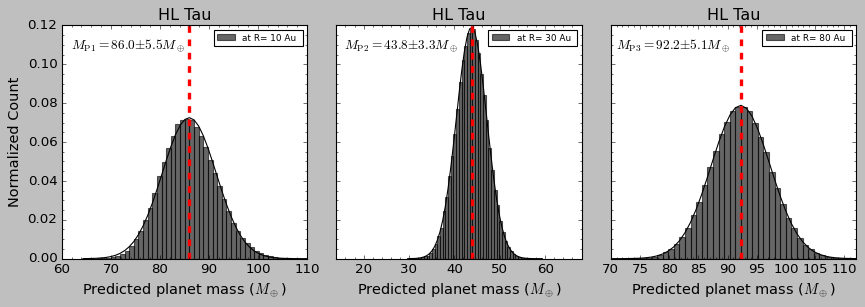

In [ ]:
df_HL0 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_epis_1per0.csv',index_col=0)
df_HL1 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_epis_1per1.csv',index_col=0)
df_HL2 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_epis_1per2.csv',index_col=0)
bi=50

f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey = True ,sharex=False,figsize=(11,4))
ax1.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
count, bins, _ = ax1.hist(df_HL0.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 10 Au ")
mu, sigma = sp.stats.norm.fit(df_HL0.iloc[:, 0])
print(round(mu,1),round(sigma,1))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# xmin, xmax = 110, 140
# x_ = np.linspace(xmin, xmax, 41)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL0.iloc[:, 0].min()-2.5
# print(x_start)
y_pos = count.max()*1.5
ax1.set_xlim(60,110)
# ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.text(x_start,y_pos,r"$M_{\rm P1}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax1.set_title("HL Tau")

_, bins, _ = ax2.hist(df_HL1.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 30 Au ")
mu, sigma = sp.stats.norm.fit(df_HL1.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL1.iloc[:, 0].min()-14
ax2.minorticks_on() 
ax2.set_xlim(14,68)
# ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax2.text(x_start,y_pos,r"$M_{\rm P2}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax2.set_title("HL Tau")

_, bins, _ = ax3.hist(df_HL2.iloc[:, 0], bins=bi,alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 80 Au ")
mu, sigma = sp.stats.norm.fit(df_HL2.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax3.plot(bins, best_fit_line,color="k")
ax3.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL2.iloc[:, 0].min()+2.6
# ax3.text(x_start,y_pos,r"$\rm PM_3$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax3.text(x_start,y_pos,r"$M_{\rm P3}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax3.set_xlim(70,112)
ax3.minorticks_on() 
ax3.set_title("HL Tau")
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
# ax1.set_ylabel(r'Count',fontsize=13)


# # plt.axis('equal')
# plt.axis('square')
plt.tight_layout()
plt.savefig('figure_Paper/HL_Tau_combined.jpeg',format='jpeg',dpi=600,bbox_inches = 'tight')

##Using DPNNet to predict the planet mass from observed gap widths in AS-209 Both epistemic and aleoteric combined

In [ ]:
#Predict the planet mass in AS 209 disk
## Note that the central star in 0.83 M_{\sun}
# AS209_1 Paramters used from Zhang et al 2018

N_epis = 200
npts_aleo = 1000

# df_AS209=np.empty((2, N))
M_star = 0.83 ## from Zhang et al 2018
Dust_gap_2 = 0.00 ## using a default value of zero

Dust_gap = 0.42
Epsilon = 0.012 # 1.23/100
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.04
Flaring_index = 0.2 ## Need to update this

df_AS209_1 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])

AS1input_params = df_AS209_1.T.values.tolist() ## df to list after transposing 
AS1input_params = [AS1input_params[i][0] for i in range(len(AS1input_params))] ## to get in a list
print(AS1input_params)
params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.01, 0.0, 0.0] ## adding a 1 percent variation in the dust gaps1 only used in paper till 9 feb
params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.05, 0.0, 0.0] ## adding a 5 percent variation in the dust gaps1 for feb 9 update
AS1Predicted_AL_EP = alea_epis_uncertainty(AS1input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

# ### Changing to Dataframe for future use
AS1_Aleo_epis  = pd.DataFrame(AS1Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

## Saving the monte Carlo for future use: 
AS1_Aleo_epis.to_csv(Path_gdrive+'data_folder/AS_Aleo_epis_5per1.csv') ## where 1per stands for i percent error in gap width

# print("The Predicted planet mass in ring AS209_1#",model.predict(Model.normalization(df_AS209_1))*M_star)

# AS209_2
Dust_gap = 0.31
Epsilon = 0.02   #####0.17/10
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.08
Flaring_index = 0.2 ## Need to update this

df_AS209_2 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
AS2input_params = df_AS209_2.T.values.tolist() ## df to list after transposing 
AS2input_params = [AS2input_params[i][0] for i in range(len(AS2input_params))] ## to get in a list
print(AS2input_params)
params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.05, 0.0, 0.0] ## adding a 5 percent variation in the dust gaps1 only
AS2Predicted_AL_EP = alea_epis_uncertainty(AS2input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

# ### Changing to Dataframe for future use
AS2AS_Aleo_epis  = pd.DataFrame(AS2Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

## Saving the monte Carlo for future use: 
AS2AS_Aleo_epis.to_csv(Path_gdrive+'data_folder/AS_Aleo_epis5per2.csv') ## where 1per stands for i percent error in gap width
# print("The Predicted planet mass in ring AS209_2#",model.predict(Model.normalization(df_AS209_2))*M_star)

[0.012, 0.0001, 0.015690000000000003, 0.04, 1.0, 0.42, 0.0, 0.2]
The uncertainty is taken from the user
The shape of the prediction list is  (1000, 200)
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
It

21.0 2.0


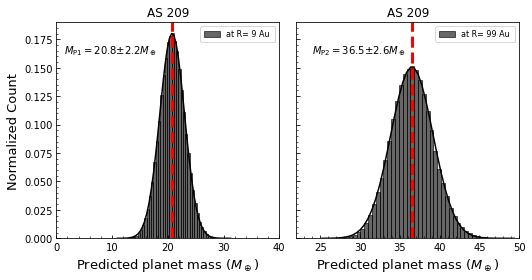

In [ ]:
## used till 9 feb in paper with 1 percent variation on gap width
# df_AS0 = pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_epis_5per1.csv',index_col=0)
# df_AS1= pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_epis5per2.csv',index_col=0)

## used till 9 feb in paper with 3 percent variation on gap width
df_AS0 = pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_epis_5per1.csv',index_col=0)
df_AS1= pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_epis5per2.csv',index_col=0)

# Correcting for the star mass
M_star = 0.83 ## from Zhang et al 2018
df_AS0 = df_AS0*M_star
df_AS1 = df_AS1*M_star
bi=50
f, [ax1,ax2] = plt.subplots(1, 2, sharey = True ,sharex=False,figsize=(7.5,4))
ax1.minorticks_on() 
count, bins, _ = ax1.hist(df_AS0.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 9 Au ")
mu, sigma = sp.stats.norm.fit(df_AS0.iloc[:, 0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_AS0.iloc[:, 0].min()-9.5
ax1.set_title("AS 209")
# print(x_start)
y_pos = count.max()*.9
# ax1.text(x_start,y_pos,r"$M_P$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.text(x_start,y_pos,r"$M_{\rm P1}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$')
# ax2.set_ylim(0,.02)
ax1.set_xlim(0,40)
ax2.minorticks_on() 
_, bins, _ = ax2.hist(df_AS1.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 99 Au ")
mu, sigma = sp.stats.norm.fit(df_AS1.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_AS1.iloc[:, 0].min()-1.3
# ax2.text(x_start,y_pos,r"$\rm M_P2$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax2.text(x_start,y_pos,r"$M_{\rm P2}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$')
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
# ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
# ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
ax2.set_xlim(22,50)
ax2.set_title("AS 209")

plt.tight_layout()
plt.savefig( "figure_Paper/AS209_planet_mass_combined.jpeg",format='jpeg',dpi=600,bbox_inches = 'tight')
# plt.tight_layout()

In [ ]:
## Measure the Aleoteric Uncertainty for HL-Yau

In [ ]:
#  Lets predict the Mass of Hl Tau disk
np.random.seed(2)
## need to guess from the observation
Epsilon = 0.01
SigmaSlope = .8 ## this is the mean value from the parameter space
Stokes = 0.005
Alpha = 0.001
Flaring_index = 0.2 ## Need to update this

## Will use the values from the Kanagawa paper
Aspect_Ratio= [0.05,0.07,0.1]
Dust_gap = [0.81,0.23,0.29]

Dust_gap_2 = 0.000 ## using a default value of zero
N_epis = 1
npts_aleo = 1000
# yhat_hL_tau = np.empty((len(Aspect_Ratio), N))
for index in range(len(Aspect_Ratio)):
  # index = 0
  df_HL = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio[index],SigmaSlope,Dust_gap[index],Dust_gap_2,Flaring_index]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
  input_params = df_HL .T.values.tolist() ## df to list after transposing 
  input_params = [input_params[i][0] for i in range(len(input_params))] ## to get in a list
  print(input_params)
  params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.1, 0.0, 0.0] ## adding a 5 percent variation in the dust gaps1 only
  Predicted_AL_EP = alea_epis_uncertainty(input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

  # ### Changing to Dataframe for future use
  HL_Aleo_epis  = pd.DataFrame(Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

  ## Saving the monte Carlo for future use: 
  HL_Aleo_epis.to_csv(Path_gdrive+'data_folder/HL_Aleo_aleo_1per'+str(index)+'.csv') ## where 1per stands for i percent error in gap width

[0.01, 0.001, 0.005, 0.05, 0.8, 0.81, 0.0, 0.2]
The uncertainty is taken from the user
The shape of the prediction list is  (1000, 1)
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iteration # 57
Iterat

96.7 40.3


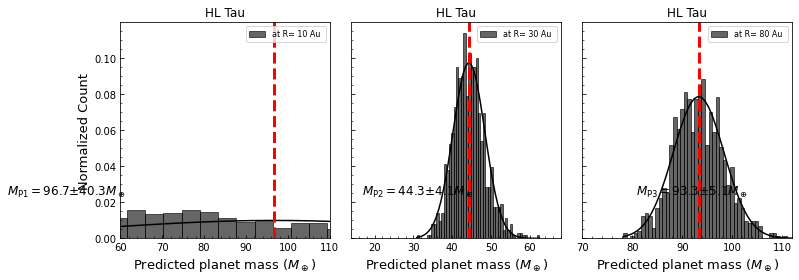

In [ ]:
df_HL0 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_aleo_1per0.csv',index_col=0)
df_HL1 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_aleo_1per1.csv',index_col=0)
df_HL2 = pd.read_csv(Path_gdrive+'data_folder/HL_Aleo_aleo_1per2.csv',index_col=0)
bi=50

f, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey = True ,sharex=False,figsize=(11,4))
ax1.minorticks_on() 
# plt.tick_params(labelsize=12)
# plt.tick_params(axis='both', which='major',length=6, width=2)
# plt.tick_params(axis='both', which='minor',length=3, width=1.3)
count, bins, _ = ax1.hist(df_HL0.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 10 Au ")
mu, sigma = sp.stats.norm.fit(df_HL0.iloc[:, 0])
print(round(mu,1),round(sigma,1))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
# xmin, xmax = 110, 140
# x_ = np.linspace(xmin, xmax, 41)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL0.iloc[:, 0].min()-2.5
# print(x_start)
y_pos = count.max()*1.5
ax1.set_xlim(60,110)
# ax1.text(x_start,y_pos,r"$\rm PM_1$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.text(x_start,y_pos,r"$M_{\rm P1}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax1.set_title("HL Tau")

_, bins, _ = ax2.hist(df_HL1.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 30 Au ")
mu, sigma = sp.stats.norm.fit(df_HL1.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL1.iloc[:, 0].min()-14
ax2.minorticks_on() 
ax2.set_xlim(14,68)
# ax2.text(x_start,y_pos,r"$\rm PM_2$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax2.text(x_start,y_pos,r"$M_{\rm P2}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax2.set_title("HL Tau")

_, bins, _ = ax3.hist(df_HL2.iloc[:, 0], bins=bi,alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 80 Au ")
mu, sigma = sp.stats.norm.fit(df_HL2.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax3.plot(bins, best_fit_line,color="k")
ax3.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_HL2.iloc[:, 0].min()+2.6
# ax3.text(x_start,y_pos,r"$\rm PM_3$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax3.text(x_start,y_pos,r"$M_{\rm P3}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$',fontsize=12)
ax3.set_xlim(70,112)
ax3.minorticks_on() 
ax3.set_title("HL Tau")
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
# ax1.set_ylabel(r'Count',fontsize=13)


# # plt.axis('equal')
# plt.axis('square')
plt.tight_layout()

## Estimate the alesoteric unsertainty for AS209

In [ ]:
N_epis = 1
npts_aleo = 1000

# df_AS209=np.empty((2, N))
M_star = 0.83 ## from Zhang et al 2018
Dust_gap_2 = 0.00 ## using a default value of zero

Dust_gap = 0.42
Epsilon = 0.012 # 1.23/100
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.04
Flaring_index = 0.2 ## Need to update this

df_AS209_1 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])

AS1input_params = df_AS209_1.T.values.tolist() ## df to list after transposing 
AS1input_params = [AS1input_params[i][0] for i in range(len(AS1input_params))] ## to get in a list
print(AS1input_params)
params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.01, 0.0, 0.0] ## adding a 10 percent variation in the dust gaps1 only
AS1Predicted_AL_EP = alea_epis_uncertainty(AS1input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

# ### Changing to Dataframe for future use
AS1_Aleo_epis  = pd.DataFrame(AS1Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

## Saving the monte Carlo for future use: 
AS1_Aleo_epis.to_csv(Path_gdrive+'data_folder/AS_Aleo_aleo_1per1.csv') ## where 1per stands for i percent error in gap width

# print("The Predicted planet mass in ring AS209_1#",model.predict(Model.normalization(df_AS209_1))*M_star)

# AS209_2
Dust_gap = 0.31
Epsilon = 0.02   #####0.17/10
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.08
Flaring_index = 0.2 ## Need to update this

df_AS209_2 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2,Flaring_index]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2","Flaring_index"])
AS2input_params = df_AS209_2.T.values.tolist() ## df to list after transposing 
AS2input_params = [AS2input_params[i][0] for i in range(len(AS2input_params))] ## to get in a list
print(AS2input_params)
params_sigma = [0.00, 0.00, 0.000, 0.00, 0.0, 0.01, 0.0, 0.0] ## adding a 10 percent variation in the dust gaps1 only
AS2Predicted_AL_EP = alea_epis_uncertainty(AS2input_params, params_sigma, N_epis=N_epis,npts_aleo=npts_aleo)

# ### Changing to Dataframe for future use
AS2AS_Aleo_epis  = pd.DataFrame(AS2Predicted_AL_EP.reshape(npts_aleo*N_epis,1))

## Saving the monte Carlo for future use: 
AS2AS_Aleo_epis.to_csv(Path_gdrive+'data_folder/AS_Aleo_aleo_1per2.csv') ## where 1per stands for i percent error in gap width
# print("The Predicted planet mass in ring AS209_2#",model.predict(Model.normalization(df_AS209_2))*M_star)

[0.012, 0.0001, 0.015690000000000003, 0.04, 1.0, 0.42, 0.0, 0.2]
The uncertainty is taken from the user
The shape of the prediction list is  (1000, 1)
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iter

In [ ]:
## Measure the Aleoteric Uncertainty for AS-209

21.0 2.0


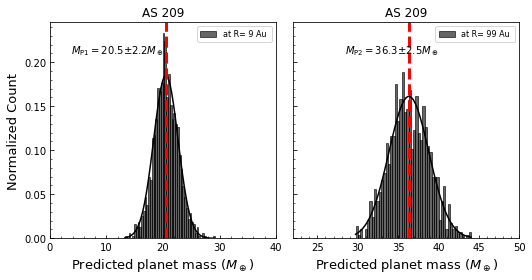

In [ ]:
df_AS0 = pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_aleo_1per1.csv',index_col=0)
df_AS1= pd.read_csv(Path_gdrive+'data_folder/AS_Aleo_aleo_1per2.csv',index_col=0)

# Correcting for the star mass
M_star = 0.83 ## from Zhang et al 2018
df_AS0 = df_AS0*M_star
df_AS1 = df_AS1*M_star
bi=50
f, [ax1,ax2] = plt.subplots(1, 2, sharey = True ,sharex=False,figsize=(7.5,4))
ax1.minorticks_on() 
count, bins, _ = ax1.hist(df_AS0.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True,label= "at R= 9 Au ")
mu, sigma = sp.stats.norm.fit(df_AS0.iloc[:, 0])
print(round(mu,0),round(sigma,0))
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, best_fit_line,color="k")
ax1.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_AS0.iloc[:, 0].min()-9.5
ax1.set_title("AS 209")
# print(x_start)
y_pos = count.max()*.9
# ax1.text(x_start,y_pos,r"$M_P$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax1.text(x_start,y_pos,r"$M_{\rm P1}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$')
# ax2.set_ylim(0,.02)
ax1.set_xlim(0,40)
ax2.minorticks_on() 
_, bins, _ = ax2.hist(df_AS1.iloc[:, 0], bins=bi, alpha=0.6,color="k",edgecolor='k',density=True, label= "at R= 99 Au ")
mu, sigma = sp.stats.norm.fit(df_AS1.iloc[:, 0])
best_fit_line = sp.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, best_fit_line,color="k")
ax2.axvline(x=mu,color="r",linestyle = "--",linewidth =3)
x_start = df_AS1.iloc[:, 0].min()-1.3
# ax2.text(x_start,y_pos,r"$\rm M_P2$ ={:.1f}$\pm${:.1f} $M_\oplus$".format(round(mu,1),round(sigma,1)),fontsize=12)
ax2.text(x_start,y_pos,r"$M_{\rm P2}=%.1f$"%round(mu,1)+r"$\pm%.1f$"%round(sigma,1)+'$M_\oplus$')
ax1.legend(loc=1,fontsize=8)
ax2.legend(loc=1,fontsize=8)
# ax3.legend(loc=1,fontsize=8)
ax1.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax2.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
# ax3.set_xlabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.set_ylabel(r'Normalized Count',fontsize=13)
ax2.set_xlim(22,50)
ax2.set_title("AS 209")

plt.tight_layout()
# plt.savefig( "figure_Paper/AS209_planet_mass_combined.jpeg",format='jpeg',dpi=600,bbox_inches = 'tight')